## Codifying the AIM fragments into CSRML and evaluating their performance against the AIM Database

#### Author: Matthew Adams
#### Principal Investigator: Grace Patlewicz

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import sys
import os
import openpyxl
%matplotlib inline


In [2]:
TOP = os.getcwd().replace('notebooks', '')
raw_dir = TOP + 'data/raw/'
interim_dir = TOP + 'data/interim/'
processed_dir = TOP + 'data/processed/'
external_dir = TOP + 'data/external/'
figures_dir = TOP + 'reports/figures/'
refs_dir = TOP + 'references/'

In [3]:


df = pd.read_csv(raw_dir+'aimdb.tsv', sep='\t', names=['SMILES','CASRN','MW','Other','AIM Fragments'])
df['AIM_list'] = df['AIM Fragments'].apply(lambda x: x.split(','))
df = df[['SMILES','AIM_list']].drop_duplicates(subset=['SMILES'])
print(df.shape)
df.head()

(83277, 2)


,SMILES,AIM_list
0,N1C(=O)NC(=O)C(F)=C1,"[5, 10, 15, 43, 58, 172, 174, 176, 206, 210, 3C]"
1,N(=O)(=O)c(ccc(O)c1N(=O)(=O))c1,"[19, 23, 34, 13C]"
2,Clc1c(Cl)cc(C(O)CNC(C)C)cc1,"[0, 1, 2, 7, 10, 19, 21, 214, 90C]"
3,c1cc(O)c(O)cc1C(O)CN(Cl)([H])([H])C(C)C,"[0, 1, 2, 7, 19, 23, 107, 127, 214]"
4,CN1C2CC(CC1C3OC23)OC(=O)C(CO)c4ccccc4,"[0, 1, 2, 7, 8, 11, 19, 40, 171, 173, 174, 82C]"


### Load Chemotyper fingerprint file

This fingerprint file was generated using the ChemoTyper tool (chemotyper.org)

 Inputs: AIM CSRML File (.xml) , AIMdb SDF File (.sdf)
 
 Output: fingerprint file (.tsv)

In [4]:
def make_df(filename):
    df = pd.read_csv(filename,sep='\t')
    df['Chemotyper_list'] = df.apply(lambda x: x.index[x == 1].tolist(), axis=1)
    df = df[['M_SMILES','Chemotyper_list']]
    df['Chemotyper_list'] = df['Chemotyper_list'].apply(lambda x: [s.split('_')[0]for s in x])
    df['Chemotyper_list'] = df['Chemotyper_list'].apply(lambda x: list(set(x)))
    df= df.rename(columns={'M_SMILES':'SMILES'})
    df = df.drop_duplicates(subset=['SMILES'])
    return df




In [5]:
df_AIM_new = make_df(raw_dir+'AIM_V1.1_vs_AIMdb_full_list_collab.tsv')

Number of unique AIM fragments captured in the AIM database

In [6]:
aims = [e for e in df_AIM_new['Chemotyper_list'] ]

In [7]:
len(list(set([e for e in aims for e in e])))

784

In [8]:
def make_df_diff(df_1,df_2):
    df_join = pd.merge(df_1,df_2,on='SMILES',how='inner')
    diff = []
    for row in df_join.itertuples():
        combined_uniques = list(set(row.Chemotyper_list).symmetric_difference(set(row.AIM_list)))
        diff.append(combined_uniques)

    df_join['Difference'] = diff
    
    return df_join

## Join the two dataframes on SMILES

This will allow us to compare the two lists of fragments:
- The original database list
- The CSRML model list

In [9]:
compare_new = make_df_diff(df,df_AIM_new)
compare_new.head()

,SMILES,AIM_list,Chemotyper_list,Difference
0,N1C(=O)NC(=O)C(F)=C1,"[5, 10, 15, 43, 58, 172, 174, 176, 206, 210, 3C]","[15, 206, 58, 172, 174, 176, 5, 210, 43, 10]",[3C]
1,N(=O)(=O)c(ccc(O)c1N(=O)(=O))c1,"[19, 23, 34, 13C]","[19, 34, 23, 13C]",[]
2,Clc1c(Cl)cc(C(O)CNC(C)C)cc1,"[0, 1, 2, 7, 10, 19, 21, 214, 90C]","[21, 1, 7, 0, 214, 19, 90C, 2, 10]",[]
3,CN1C2CC(CC1C3OC23)OC(=O)C(CO)c4ccccc4,"[0, 1, 2, 7, 8, 11, 19, 40, 171, 173, 174, 82C]","[1, 11, 40, 82C, 7, 173, 0, 174, 19, 8, 2, 171]",[]
4,O=C(O)C(NCC1O)C1,"[1, 2, 7, 10, 35, 171, 174, 6C, 7C]","[7C, 1, 6C, 35, 7, 174, 2, 171, 10]",[]


In [27]:
compare_new.shape

(73179, 5)

## Evaluating the performance of the individual fragments

Next we want to evaluate the performance of each individual fragment.

To do so, we get the  TP, TN, FP, FN values of each fragment to calculate individual evaluation metrics

------
## Evaluation metrics:
- Accuracy (TP + TN)/ (TP + FN + FP + TN)
- Sensitivity (TP)/(TP + FN) True positive rate, recall
- Specificity (TN) / (FP + TN) True negative rate
- Precision (TP) / (TP + FP) Positive predictive value
- Jaccard Similarity, TP / (TP + FN + FP)


In [10]:
import numpy as np
def comparison_table(df):
    df['Number_different'] = df['Difference'].apply(lambda x: len(x))
    fragments = []
    for row in df["AIM_list"]:  #Possibly switch to Difference columns in case the CSRML matches with fragments that do not show up at all within the dataset for AIM
        for fragment in row:
            fragments.append(fragment)

    fragments = list(set(fragments))
    total_rows = df.shape[0]
    diffs = []

    for i in fragments:
        selection = [i]
        aim_mask = df['AIM_list'].apply(lambda x: any(item for item in selection if item in x))
        df_aim = df[aim_mask]
        chemo_mask = df['Chemotyper_list'].apply(lambda x: any(item for item in selection if item in x))
        TP = df_aim[chemo_mask].shape[0]  #Both AIM and Chemo (TP)


        err_mask = df['Difference'].apply(lambda x: any(item for item in selection if item in x))
        df_diff = df[err_mask]  #Total number of errors (FN,FP)
    
        avg_err = np.round(df_diff.iloc[:,-1].mean(),2) #number of totalmismatches in structures which contain a mismatch with selection
        diff_total = df_diff.shape[0]
        chemo_mask = df_diff['Chemotyper_list'].apply(lambda x: any(item for item in selection if item in x))

        FP = df_diff[chemo_mask].shape[0]
        FN = diff_total - FP
        TN = total_rows - (FP+FN+TP)
        diffs.append([TP,FP,FN,TN,avg_err])


    mismatch = df[df['Difference'].map(lambda d: len(d)) > 0]
    full_match = round(1 -(len(mismatch)/len(df)),3)
    print('Percent full match: ' + str(100*full_match) + '%')
    df_diff = pd.DataFrame.from_dict(dict(zip(fragments,diffs))).T
    df_diff = df_diff.rename(columns={df_diff.columns[0]:'TP',
                                  df_diff.columns[1]:'FP',
                                  df_diff.columns[2]:'FN',
                                  df_diff.columns[3]:'TN',
                                  df_diff.columns[4]:'Avg total mismatch'})
    df_diff = df_diff.fillna(0)
    df_diff[['TP','FP','FN','TN']] = df_diff[['TP','FP','FN','TN']].astype(int)
    
    df_diff['Accuracy (TP+TN)/Total'] = np.round(df_diff[['TP','TN']].sum(axis=1).div(df_diff[['TP','FN','FP','TN']].sum(axis=1)),3)
    df_diff['Sensitivity (TP) / (TP+FN)'] = np.round(df_diff['TP'].div(df_diff[['TP','FN']].sum(axis=1)),3)
    df_diff['Specificity (TN) / (FP+TN)'] = np.round(df_diff['TN'].div(df_diff[['FP','TN']].sum(axis=1)),3)
    df_diff['Precision (TP) / (TP+FP)'] = np.round(df_diff['TP'].div(df_diff[['TP','FP']].sum(axis=1)),3)
    df_diff['Jaccard (TP) / (TP+FP+FN)'] = np.round(df_diff['TP'].div(df_diff[['TP','FP','FN']].sum(axis=1)),3)

    return df_diff

In [11]:
newest_version =  comparison_table(compare_new)

<ipython-input-10-a81adf660d7d>:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  TP = df_aim[chemo_mask].shape[0]  #Both AIM and Chemo (TP)


Percent full match: 74.3%


In [13]:
newest_version.head()

,TP,FP,FN,TN,Avg total mismatch,Accuracy (TP+TN)/Total,Sensitivity (TP) / (TP+FN),Specificity (TN) / (FP+TN),Precision (TP) / (TP+FP),Jaccard (TP) / (TP+FP+FN)
10E,0,1,1,73177,3.50,1.000,0.000,1.0,0.000,0.000
204,5413,3,165,67598,1.91,0.998,0.970,1.0,0.999,0.970
4E,32,0,0,73147,0.00,1.000,1.000,1.0,1.000,1.000
38E,10,1,1,73167,3.50,1.000,0.909,1.0,0.909,0.833
57X,2,0,0,73177,0.00,1.000,1.000,1.0,1.000,1.000


In [26]:
newest_version.index

Index(['10E', '204', '4E', '38E', '57X', '61C', '152C', '1', '242C', '365C',
       ...
       '64C', '151', '7', '205', '202', '80X', '5', '324C', '408C', '341C'],
      dtype='object', length=750)

In [12]:
newest_version.mean()

TP                              833.684000
FP                               16.180000
FN                               18.222667
TN                            72310.913333
Avg total mismatch                1.824840
Accuracy (TP+TN)/Total            0.999577
Sensitivity (TP) / (TP+FN)        0.895613
Specificity (TN) / (FP+TN)        0.999793
Precision (TP) / (TP+FP)          0.906284
Jaccard (TP) / (TP+FP+FN)         0.822136
dtype: float64

## Plot Distribution of our Fragments:

We can see how some fragments are responsible for lower performance


In [107]:
import matplotlib.pyplot as plt
def plot_hist(df):
    X = df['Jaccard (TP) / (TP+FP+FN)']
    fig,ax1 = plt.subplots(ncols=1, figsize = (9,6))
    #print(X)
    #fig.set_size_inches(6, 4)
    
    #plt.xlim([0,1.1])
    values, base = np.histogram(X,bins=10)
    
    cumulative=np.cumsum(values)
    cdf = cumulative / sum(values)
    n,bins,patches = ax1.hist(X,bins=10,range=(0,1),linewidth=1,edgecolor='black')
    #ax1.set_title('AIM Translation Evaluation',fontsize=24)
    ax1.set_ylabel('Frequency',fontsize=18)
    #ax1.set_xlim(0,1.2)
    ax1.set_xlabel('Jaccard similarity',fontsize=18)
    ax2 = ax1.twinx()
    ax2.plot(base[:-1],cdf,c='orange')
    ax2.set_ylim(0,1)
    ax2.set_ylabel('CDF',fontsize=18)
    fig.savefig(figures_dir+'Figure_2.png', dpi = 300)

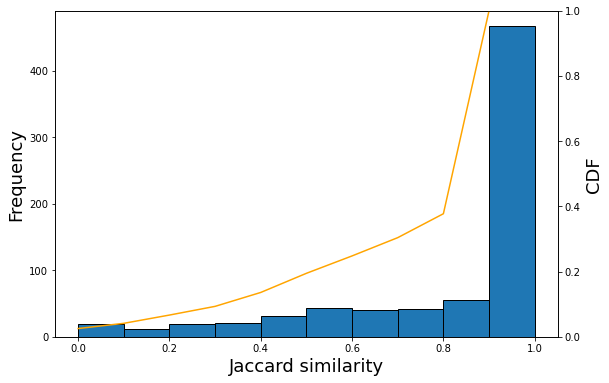

In [108]:
plot_hist(newest_version)

In [14]:
df_AIM_old = make_df(raw_dir+'AIM_V0_vs_AIMdb_full_list_collab.tsv')

In [15]:
compare_old = make_df_diff(df,df_AIM_old)

In [16]:
oldest_version  =  comparison_table(compare_old)

<ipython-input-10-a81adf660d7d>:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  TP = df_aim[chemo_mask].shape[0]  #Both AIM and Chemo (TP)


Percent full match: 0.0%


In [24]:
oldest_version.shape

(750, 10)

In [18]:
oldest_version.mean()

TP                              561.132000
FP                              330.230667
FN                              290.774667
TN                            71996.862667
Avg total mismatch                9.728147
Accuracy (TP+TN)/Total            0.991560
Sensitivity (TP) / (TP+FN)        0.361087
Specificity (TN) / (FP+TN)        0.995269
Precision (TP) / (TP+FP)          0.560671
Jaccard (TP) / (TP+FP+FN)         0.270609
dtype: float64

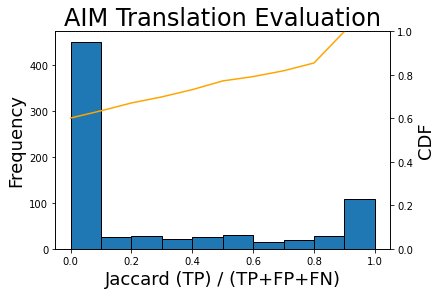

In [22]:
oldest_version['Jaccard (TP) / (TP+FP+FN)'] = np.round(oldest_version['TP'].div(oldest_version[['TP','FP','FN']].sum(axis=1)),3)

plot_hist(oldest_version)

#### Reconciling the numbers of original AIM fragments depending on source - AIM database or ChemACE Appendix

Counts of Appendix fragments

In [50]:
orig_appendix = pd.read_excel(raw_dir+'AppendixB_AIM_465_fragments_v060718.xlsx', sheet_name = 'AppendixA_Original')

In [51]:
orig_appendix = orig_appendix[orig_appendix['Number'].notnull()]

In [52]:
orig_appendix2 = orig_appendix[orig_appendix['Fragment'].notnull()]

In [53]:
orig_appendix2['Fragment'].nunique()

787

In [76]:
orig_appendix['Number']

831

Original database

In [57]:
aim_db = pd.read_csv(raw_dir+'aimdb.tsv', sep = '\t', header = None)

In [59]:
aim_db.columns = ['smiles', 'cas', 'mw', 'fragment', 'fragment_list']

In [110]:
aim_db.shape

(86200, 5)

In [64]:
aim_ids = [e.split(',') for e in aim_db['fragment_list'] ]

In [70]:
aim_ids = [i for e in aim_ids for i in e]

In [77]:
unique_aim = list(set(aim_ids))

In [93]:
print('There were {} unique fragments in the AIM database'.format(len(unique_aim)))

There were 767 unique fragments in the AIM database


In [91]:
len([e for e in orig_appendix2['Number'].astype(str) if e  in unique_aim ])

67

In [103]:
sorted(orig_appendix2['Number'].astype(str))[0:10]

['0', '0C', '0E', '0X', '1', '10', '100', '100C', '100X', '101']

In [104]:
sorted(unique_aim)[0:10]

['0', '0C', '0E', '0X', '1', '10', '100', '100C', '100X', '101']